In [10]:
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np

iv_raw = pd.read_csv("../output/features_data.csv")

max_dte = 40 / 365.25
iv_short = iv_raw[iv_raw['texp'] <= max_dte].copy()
iv_short['c_date'] = pd.to_datetime(iv_short['c_date']).dt.normalize()
iv_short['expiry'] = pd.to_datetime(iv_short['expiry']).dt.normalize()

# Set up NYSE calendar
nyse = mcal.get_calendar('NYSE')
global_dates = nyse.valid_days(start_date=iv_raw['c_date'].min(), end_date=iv_raw['c_date'].max()).tz_convert(None).normalize()

# Load earnings file
earnings_df = pd.read_csv("../data/earnings_calendar.csv")
earnings_df = earnings_df.dropna(subset=['act_symbol'])
earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.normalize() 
earnings_lookup = earnings_df.groupby('act_symbol')['date'].apply(set).to_dict()

def earnings_conflict(row):
    symbol = row['ticker']
    if symbol not in earnings_lookup:
        return False
    return any(row['c_date'] <= edate <= row['expiry'] for edate in earnings_lookup[symbol])

iv_short = iv_short[~iv_short.apply(earnings_conflict, axis=1)]

def get_avg_two_shortest(group):
    sorted_group = group.sort_values('texp')
    return sorted_group['atm_iv'].iloc[:2].mean()
""""
iv_summary = (
    iv_short.groupby(['c_date', 'ticker'])
    .apply(get_avg_two_shortest)
    .unstack()
    .sort_index()
)

# Choose a summary statistic — e.g., ATM IV
"""
iv_summary = (
    iv_short.groupby(['c_date', 'ticker'])['atm_iv']
    .mean()
    .unstack()
    .sort_index()
)

isna = iv_summary.isna()
nan_ratio = isna.mean().mean()
print(f"Overall missing rate: {nan_ratio:.2%}")

missing_by_ticker = isna.mean()
missing_by_date = isna.mean(axis=1)
missing_by_ticker


Overall missing rate: 21.89%


ticker
A       0.217565
AAL     0.087824
AAP     0.147705
AAPL    0.071856
ABBV    0.087824
          ...   
NFLX    0.055888
NI      0.706587
NKE     0.059880
NOC     0.069860
NOW     0.413174
Length: 333, dtype: float64

In [12]:
# Function to build IV matrix
def build_iv_matrix(iv_raw, earnings_df, max_dte_days=40, mode='avg2'):
    max_dte = max_dte_days / 252

    iv = iv_raw.copy()
    iv['c_date'] = pd.to_datetime(iv['c_date']).dt.normalize()
    iv['expiry'] = pd.to_datetime(iv['expiry']).dt.normalize()
    iv = iv[iv['texp'] <= max_dte]

    earnings_lookup = earnings_df.groupby('act_symbol')['date'].apply(set).to_dict()

    def earnings_conflict(row):
        symbol = row['ticker']
        if symbol not in earnings_lookup:
            return False
        return any(row['c_date'] <= edate <= row['expiry'] for edate in earnings_lookup[symbol])

    iv = iv[~iv.apply(earnings_conflict, axis=1)]

    if mode == 'min':
        iv_summary = (
            iv.sort_values('texp')
              .groupby(['c_date', 'ticker'])
              .first()['atm_iv']
              .unstack()
              .sort_index()
        )
    elif mode == 'avg2':
        def avg_two_shortest(group):
            sorted_group = group.sort_values('texp')
            return sorted_group['atm_iv'].iloc[:2].mean()

        iv_summary = (
            iv.groupby(['c_date', 'ticker'])
              .apply(avg_two_shortest)
              .unstack()
              .sort_index()
        )
    else:
        raise ValueError("mode must be 'min' or 'avg2'")

    return iv_summary

iv_raw = pd.read_csv("../output/features_data.csv")
earnings_df = pd.read_csv("../data/earnings_calendar.csv")
earnings_df = earnings_df.dropna(subset=['act_symbol'])
earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.normalize() 
iv_matrix = build_iv_matrix(iv_raw, earnings_df, max_dte_days=40, mode='avg2')

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_3249/3197560705.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(avg_two_shortest)


Text(0, 0.5, 'Date')

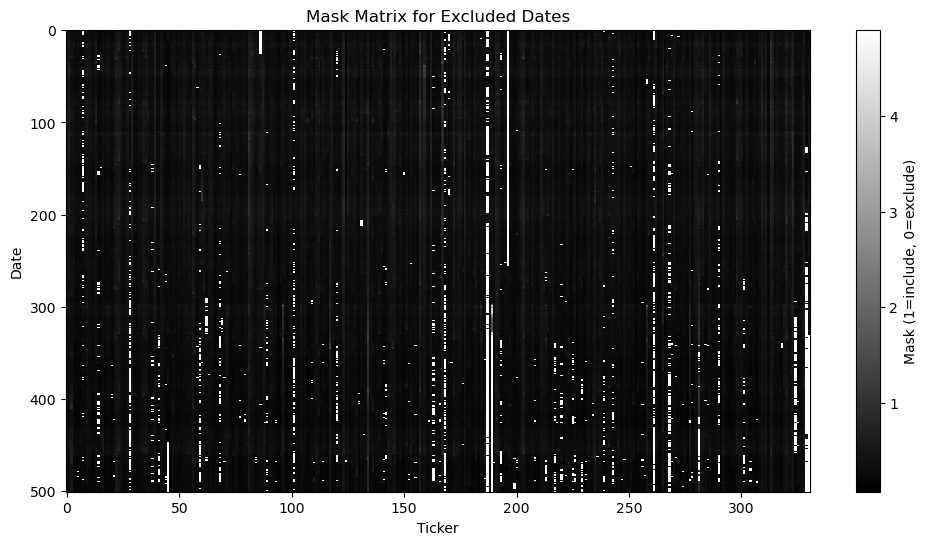

In [17]:
iv_summary

import matplotlib.pyplot as plt
iv_summary
#visualize the matrix
plt.figure(figsize=(12, 6))
plt.imshow(iv_summary, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Mask (1=include, 0=exclude)')
plt.title('Mask Matrix for Excluded Dates')
plt.xlabel('Ticker')
plt.ylabel('Date')  

Text(0, 0.5, 'Date index')

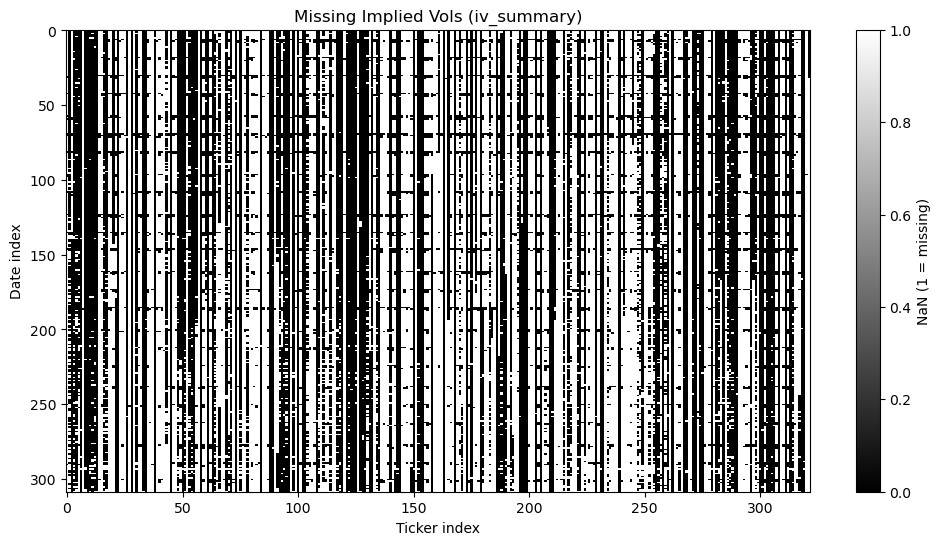

In [10]:
isna = iv_summary.isna()
plt.figure(figsize=(12, 6))
plt.imshow(isna, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='NaN (1 = missing)')
plt.title('Missing Implied Vols (iv_summary)')
plt.xlabel('Ticker index')
plt.ylabel('Date index')

In [12]:
nan_ratio = isna.mean().mean()
print(f"Overall missing rate: {nan_ratio:.2%}")

missing_by_ticker = isna.mean()
missing_by_date = isna.mean(axis=1)
missing_by_ticker

Overall missing rate: 51.82%


ticker
A       0.951456
AAL     0.304207
AAP     0.423948
AAPL    0.132686
ABBV    0.129450
          ...   
NEE     0.773463
NEM     0.006472
NFLX    0.006472
NI      0.996764
NKE     0.896440
Length: 322, dtype: float64

In [31]:
iv_summary

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE
c_date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.237976,0.451635,0.262280,0.267771,0.224131,0.226744,0.222007,NaN,0.203534,0.268588,...,0.256713,0.368860,0.535138,0.229656,0.232888,0.194279,0.280514,0.349158,0.178930,0.214463
2022-01-04,0.263211,0.453535,0.247694,0.279205,0.224870,0.244387,0.233864,NaN,0.220463,0.293118,...,0.270150,0.380560,0.522724,0.215387,0.231011,0.202678,0.281071,0.362776,0.171349,0.212000
2022-01-05,0.292915,0.488696,0.264285,0.318735,0.243396,0.293288,0.249413,NaN,0.249946,0.346084,...,0.290978,0.402529,0.569324,0.249563,0.252707,0.213136,0.283162,0.406710,0.169209,0.239217
2022-01-06,0.271906,0.500313,0.272462,0.311714,0.233891,0.263962,0.246509,NaN,0.284003,0.326771,...,0.298064,0.398240,0.562154,0.237344,0.260366,0.227458,0.291484,0.408805,0.194128,0.236741
2022-01-07,0.283907,0.489454,0.270205,0.290440,0.228682,0.269616,0.245847,NaN,0.255097,0.310975,...,0.305522,0.385426,0.556419,0.248523,0.255251,0.223260,0.284892,0.421461,0.190449,0.232951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.244660,0.385619,0.498646,0.181073,0.172903,0.172693,0.176605,0.251416,0.164901,0.248865,...,0.288931,0.281087,0.435892,0.197811,0.180034,0.273927,0.299003,0.310643,NaN,NaN
2023-12-26,0.250709,0.405367,0.513830,0.188456,0.182504,0.181037,0.181208,0.250832,0.171697,0.258233,...,0.294170,0.299975,0.460639,0.198397,0.171140,0.292623,0.308868,0.322688,NaN,NaN
2023-12-27,0.246144,0.403195,0.501696,0.187938,0.180173,0.182615,0.179474,0.242706,0.164945,0.249571,...,0.291483,0.287010,0.443118,0.195513,0.161670,0.282430,0.299907,0.321435,NaN,NaN


In [32]:
# Load earnings file
earnings_df = pd.read_csv("../data/earnings_calendar.csv")
earnings_df = earnings_df.dropna(subset=['act_symbol'])
earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.normalize() 

In [30]:
import pandas_market_calendars as mcal
import numpy as np

# Load earnings file
earnings_df = pd.read_csv("../data/earnings_calendar.csv")
earnings_df = earnings_df.dropna(subset=['act_symbol'])
earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.normalize() 
earnings_dict={}
# Set up NYSE calendar
nyse = mcal.get_calendar('NYSE')
min_date, max_date = earnings_df['date'].min(), earnings_df['date'].max()
trading_days = nyse.valid_days(start_date=min_date, end_date=max_date)

# Generate exclusion set: (ticker, excluded_date) for ±1 trading day
excluded_dates = []
#global_dates = nyse.valid_days(start_date=df['date'].min(), end_date=df['date'].max()).tz_convert(None).normalize()
for _, row in earnings_df.iterrows():
    symbol = row['act_symbol']
    if symbol not in earnings_dict.keys():
        earnings_dict[symbol] = []
    date = row['date']
    #print(f"Processing earnings for {symbol} on {date}")
    #if 'AAPL' in earnings_dict.keys():
    #    print(f"symbol: {symbol} apple earning dates: {earnings_dict[symbol]}")
    if date in global_dates:
        
        idx = global_dates.get_loc(date)
        #print(f"Processing earnings for {symbol} on {date}, index {idx} in global_dates")
        for offset in [-1, 0, 1]:
            #if symbol == 'AAPL':
            #    print(f"symbol: {symbol}, date: {date}, idx: {idx}, offset: {offset}")
            if 0 <= idx + offset < len(global_dates):
                if symbol == 'AAPL':
                    print(f"symbol: {symbol}, date: {date}, idx: {idx}, offset: {offset}")
                earnings_dict[symbol].append(global_dates[idx + offset].date())
                excluded_dates.append((symbol, global_dates[idx + offset].date()))
                if symbol == 'AAPL':
                    print(f"Added excluded date for {symbol}: {earnings_dict[symbol]}")

#for symbol, dates in earnings_dict.items():
#    earnings_dict[symbol] = set(dates)  # Convert to set for fast lookup

# Convert to set for fast lookup
excluded_mask_set = set(excluded_dates)
# Create mask matrix where True = include, False = exclude
mask_matrix = np.ones_like(iv_summary, dtype=bool)

for (ticker, date) in excluded_mask_set:
    if ticker in iv_summary.columns and pd.Timestamp(date) in global_dates:
        mask_matrix[iv_summary.index.get_loc(pd.Timestamp(date)), iv_summary.columns.get_loc(ticker)] = False

symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: -1
Added excluded date for AAPL: [datetime.date(2022, 4, 27)]
symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: 0
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28)]
symbol: AAPL, date: 2022-04-28 00:00:00, idx: 80, offset: 1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: -1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29), datetime.date(2022, 7, 27)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: 0
Added excluded date for AAPL: [datetime.date(2022, 4, 27), datetime.date(2022, 4, 28), datetime.date(2022, 4, 29), datetime.date(2022, 7, 27), datetime.date(2022, 7, 28)]
symbol: AAPL, date: 2022-07-28 00:00:00, idx: 142, offset: 1
Added excluded date for AAPL: [datetime.date(2022, 4, 27), d